## VAEで画像を再生成するよう訓練する

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
%matplotlib inline

### データの前処理

In [2]:
rng = np.random.RandomState(1234)
random_state = 42

batch_size = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
n_epochs = 20

transform = transforms.Compose([
    transforms.ToTensor(),  # [0, 255] -> [0.0, 1.0]
    transforms.Lambda(lambda x: x.view(-1))])  # (H, W, C) -> 784次元に平坦化


#Train, Valid用データローダーの作成
dataloader_train = torch.utils.data.DataLoader(
    datasets.MNIST('./data/MNIST', train=True,  # 訓練データとして取り出す
                   download=True,  # ローカルにない場合のみダウンロード
                   transform=transform),  # 取り出すとき型変更
    batch_size=batch_size,  # バッチサイズも指定、1エポックで60000/100=600回データをとる
    shuffle=False  # 画像を取り出す順番
)

dataloader_valid = torch.utils.data.DataLoader(
    datasets.MNIST('./data/MNIST', train=False, download=True,
                   transform=transform),
    batch_size=batch_size,
    shuffle=False
)

cuda


100%|██████████| 9912422/9912422 [00:00<00:00, 107072211.00it/s]


Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 121989621.17it/s]


Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 40105608.82it/s]


Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18918102.05it/s]


Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



### モデルの定義

In [3]:
def torch_log(x):  # torch.log(0)によるnanを防ぐ
    return torch.log(torch.clamp(x, min=1e-10))

In [4]:
class VAE(nn.Module):  # VAEモデルの実装
    def __init__(self, z_dim):
        super(VAE, self).__init__()
        # Encoder, xを入力にガウス分布のパラメータmu, sigmaを出力
        self.dense_enc1 = nn.Linear(28*28, 200)  # 全結合層(Denseと同義)
        self.dense_enc2 = nn.Linear(200, 200)
        self.dense_encmean = nn.Linear(200, z_dim)
        self.dense_encvar = nn.Linear(200, z_dim)
        # Decoder, zを入力にベルヌーイ分布のパラメータlambdaを出力
        self.dense_dec1 = nn.Linear(z_dim, 200)
        self.dense_dec2 = nn.Linear(200, 200)
        self.dense_dec3 = nn.Linear(200, 28*28)

    def _encoder(self, x):
        x = F.relu(self.dense_enc1(x))  # 一層ごとにReluを通す
        x = F.relu(self.dense_enc2(x))
        mean = self.dense_encmean(x)
        std = F.softplus(self.dense_encvar(x))
        return mean, std  # それぞれ10次元

    def _sample_z(self, mean, std):
        # 再パラメータ化トリック
        epsilon = torch.randn(mean.shape).to(device)
        return mean + std * epsilon  # 10個の要素(×特徴量)を元に生成する。
        # 1の画像なら、この要素を重視するけど、こっちのはどうでもいいのでstd大きくしよう。みたいな感じ。
        # 重視する場合は、stdを小さくして、そのままmeanが返されるように学習する。

    def _decoder(self, z):
        x = F.relu(self.dense_dec1(z))
        x = F.relu(self.dense_dec2(x))
        # 出力が0~1になるようにsigmoid
        x = torch.sigmoid(self.dense_dec3(x))
        return x

    def forward(self, x):  # 順伝搬関数、継承クラスで必要
        mean, std = self._encoder(x)
        z = self._sample_z(mean, std)
        x = self._decoder(z)
        return x, z  # 2つ返す必要ある？あります。model(x)とすると2つ返される。

    def loss(self, x):
        mean, std = self._encoder(x)
        # KL loss(正則化項)の計算. mean, stdは (batch_size , z_dim)
        # torch.sumは上式のJ(=z_dim)に関するもの. torch.meanはbatch_sizeに関するものなので,上式には書いてありません.
        KL = -0.5 * torch.mean(
            torch.sum(1 + torch_log(std**2) - mean**2 - std**2, dim=1))
        # 潜在変数の値は、std=+-0.659、mean=0に近づく。stdは小さすぎたら過学習だし、大きすぎたら学習できてない。

        z = self._sample_z(mean, std)
        y = self._decoder(z)

        # reconstruction loss(負の再構成誤差)の計算. x, yともに (batch_size , 784)
        # torch.sumは上式のD(=784)に関するもの. torch.meanはbatch_sizeに関するもの.
        reconstruction = torch.mean(
            torch.sum(x * torch_log(y) + (1 - x) * torch_log(1 - y), dim=1))

        return KL, -reconstruction

### 学習

In [5]:
z_dim = 10
assert z_dim >= 2

model = VAE(z_dim).to(device)
# lossの計算をclassの外で計算する場合は、ここで定義
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(n_epochs):
    losses = []
    KL_losses = []
    reconstruction_losses = []
    num = 0

    model.train()  # 訓練モード、正則化やDropOutを行う
    for x, _ in dataloader_train:
        # print('\r%3d回目' % num, end='')
        num += 1
        x = x.to(device)
        model.zero_grad()  # 前回計算した勾配を初期化、pytorchならでは。
        # optimizer.zero_grad()  # 本ではこっち。どっちでもいい？

        # KL_loss, reconstruction_lossの各項の計算
        KL_loss, reconstruction_loss = model.loss(x)

        # エビデンス下界の最大化のためマイナス付きの各項の値を最小化するようにパラメータを更新
        loss = KL_loss + reconstruction_loss

        loss.backward()  # 誤差伝搬
        optimizer.step()  # Adamでテンソル(パラメータ)を計算

        losses.append(loss.cpu().detach().numpy())
        KL_losses.append(KL_loss.cpu().detach().numpy())
        reconstruction_losses.append(
            reconstruction_loss.cpu().detach().numpy())

    losses_val = []
    model.eval()  # 検証モード
    for x, t in dataloader_valid:
        x = x.to(device)

        KL_loss, reconstruction_loss = model.loss(x)
        loss = KL_loss + reconstruction_loss
        losses_val.append(loss.cpu().detach().numpy())

    # 検証の方が小さくなる時があるのは、訓練ははじめの学習してない時も平均してるから。
    print('エポック: %d   訓練loss: %lf (KLloss: %lf + 再構成loss: %lf)   検証loss: %lf' %
          (epoch+1, np.average(losses), np.average(KL_losses), np.average(reconstruction_losses), np.average(losses_val)))


エポック: 1   訓練loss: 191.888535 (KLloss: 4.996205 + 再構成loss: 186.892334)   検証loss: 155.850372
エポック: 2   訓練loss: 141.706696 (KLloss: 11.192379 + 再構成loss: 130.514328)   検証loss: 130.892242
エポック: 3   訓練loss: 125.921967 (KLloss: 13.953975 + 再構成loss: 111.967995)   検証loss: 124.053185
エポック: 4   訓練loss: 120.638748 (KLloss: 14.592532 + 再構成loss: 106.046219)   検証loss: 120.042648
エポック: 5   訓練loss: 117.377602 (KLloss: 15.222702 + 再構成loss: 102.154884)   検証loss: 115.665520
エポック: 6   訓練loss: 114.576248 (KLloss: 15.891201 + 再構成loss: 98.685036)   検証loss: 114.033875
エポック: 7   訓練loss: 112.894806 (KLloss: 16.181442 + 再構成loss: 96.713356)   検証loss: 113.413368
エポック: 8   訓練loss: 111.601692 (KLloss: 16.364849 + 再構成loss: 95.236839)   検証loss: 111.090057
エポック: 9   訓練loss: 110.484634 (KLloss: 16.561218 + 再構成loss: 93.923409)   検証loss: 110.424774
エポック: 10   訓練loss: 109.563202 (KLloss: 16.849203 + 再構成loss: 92.713997)   検証loss: 110.032616
エポック: 11   訓練loss: 108.632362 (KLloss: 17.154011 + 再構成loss: 91.478355)   検証loss: 109.

### モデルの保存

In [6]:
# Google DriveをColabにマウント
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

import os
work_dir = '/content/drive/MyDrive/masa/'
os.chdir(work_dir)

Mounted at /content/drive


In [8]:
torch.save(model.cpu().state_dict(), './vae/vae.pth')
model = model.to(device)

In [ ]:
model = VAE(z_dim)
model.load_state_dict(torch.load('./vae/vae.pth'))
model = model.to(device)

### 結果

100%|██████████| 9912422/9912422 [00:00<00:00, 28686317.63it/s]


Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 164363220.93it/s]

Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:03<00:00, 459199.67it/s]


Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 74892.69it/s]


Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



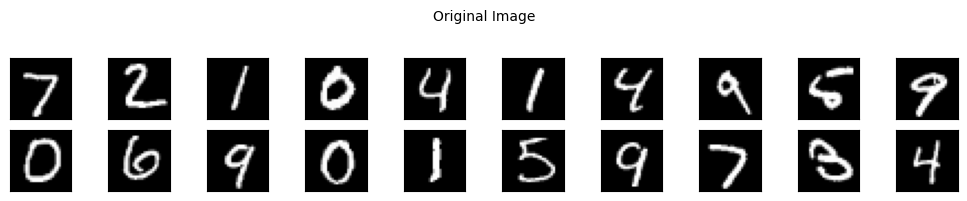

In [9]:
# テストデータの表示
valid_dataset = datasets.MNIST(
    './data/MNIST', train=False, download=True, transform=transform)
fig = plt.figure(figsize=(10, 2))
fig.suptitle('Original Image', fontsize=10)

for i in range(20):
    x, t = valid_dataset[i]
    im = x.view(-1, 28, 28).permute(1, 2, 0).squeeze().numpy()
    # permuteは軸の入れ替え
    ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])  # 縦2、横10のi+1番目
    ax.imshow(im, 'gray')
fig.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()

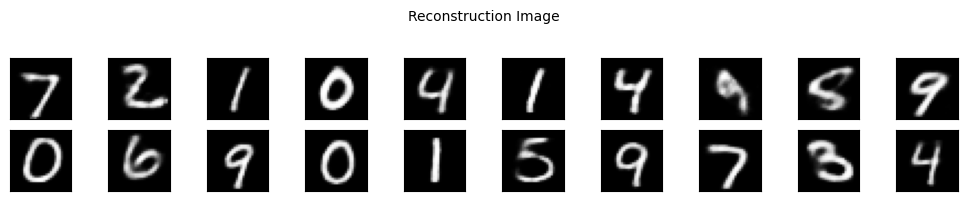

In [10]:
# データを元に再構成したものの表示
valid_dataset = datasets.MNIST(
    './data/MNIST', train=False, download=True, transform=transform)
fig = plt.figure(figsize=(10, 2))
fig.suptitle('Reconstruction Image', fontsize=10)

model.eval()
for i in range(20):
    x, t = valid_dataset[i]
    x = x.to(device).unsqueeze(0)  # [784] -> [1, 784]
    y, z = model(x)
    im = y.view(-1, 28, 28).permute(1, 2,
                                    0).cpu().squeeze().detach().numpy()
    ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

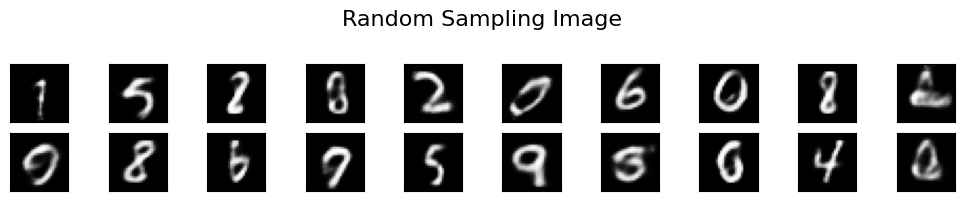

In [11]:
# ランダムな変数をzの代わりに使う
# 何かしら数字を作ろうとしてるのが見れる
fig = plt.figure(figsize=(10, 2))
fig.suptitle('Random Sampling Image', fontsize=16)

model.eval()
for i in range(20):
    # 標準正規分布からサイズ(1, z_dim)の乱数を生成
    z = torch.randn([1, z_dim]).to(device)
    y = model._decoder(z)
    im = y.view(-1, 28, 28).permute(1, 2,
                                    0).cpu().squeeze().detach().numpy()
    ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

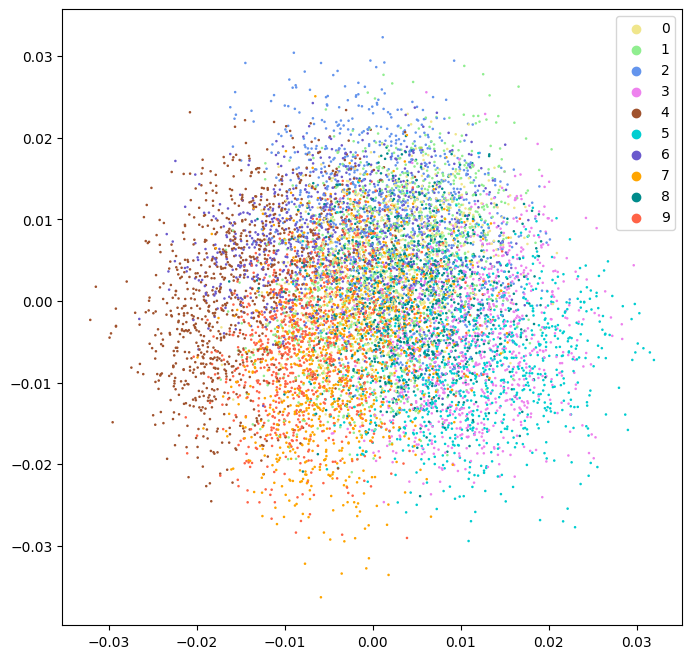

In [18]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# 10次元の特徴量zをそのまま2次元に次元削減してるだけ。
dim_red = 'PCA'  # 'TSNE' または 'PCA'、PCAだとほどんど被ってみえる。

valid_dataset = datasets.MNIST(
    './data/MNIST', train=False, download=True, transform=transform)
model.eval()
t_list = []
z_list = []
for x, t in valid_dataset:
    t_list.append(t)
    x = x.to(device).unsqueeze(0)
    y, z = model(x)
    z_list.append(z.cpu().detach().numpy()[0])

if z_dim == 2:
    z_list = np.array(z_list).T
else:
    if dim_red == 'TSNE':
        z_list = TSNE(n_components=2).fit_transform(np.array(z_list).T)
    elif dim_red == 'PCA':
        z_list = PCA(n_components=2).fit(np.array(z_list).T).components_
    else:
        raise ValueError()

colors = ['khaki', 'lightgreen', 'cornflowerblue', 'violet', 'sienna', 'darkturquoise', 'slateblue', 'orange',
            'darkcyan', 'tomato']
# 2次元用
plt.figure(figsize=(8, 8))
plt.scatter(z_list[0], z_list[1], s=0.7, c=[colors[t] for t in t_list])
for i in range(10):
    plt.scatter([], [], c=colors[i], label=i)
plt.legend()
plt.show()

# 3次元用
# fig = plt.figure()
# ax = Axes3D(fig)
# ax.scatter(z_list[0], z_list[1], z_list[2], s=0.7, c=[colors[t] for t in t_list])
# plt.show()

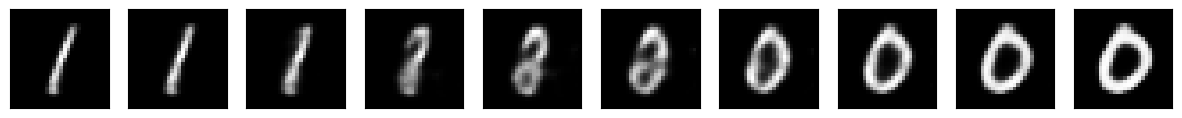

In [19]:
# 3番目のデータの1と、4番目のデータの0を与えたときに得られるzを、内分して繋いでいく。
valid_dataset = datasets.MNIST(
    './data/MNIST', train=False, download=True, transform=transform)

model.eval()
x0, t = valid_dataset[2]
x0 = x0.to(device).unsqueeze(0)
y0, z0 = model(x0)

x1, t = valid_dataset[3]
x1 = x1.to(device).unsqueeze(0)
y1, z1 = model(x1)

fig = plt.figure(figsize=(15, 2))
z_linear = torch.cat([z1 * (i * 0.1) + z0 * ((9 - i) * 0.1)
                        for i in range(10)])
# z_dimの潜在空間内で, 1を生成したベクトルから0を生成したベクトルへ少しずつ移動していきます.
z_linear = z_linear.view((10, -1))
y2 = model._decoder(z_linear).view(-1, 28, 28).cpu().detach().numpy()
for i, im in enumerate(y2):
    ax = fig.add_subplot(1, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')
plt.show()
